### Static Prey 
Random Positions

In [3]:
import numpy as np
import multimodal_mazes
import matplotlib.pyplot as plt
from scipy import signal

In [ ]:
# Assuming the necessary variables are defined: size, agnt.channels, pk_hw
size = 7  # example size, you should use your actual size
agnt_channels = 2  # example number of channels, you should use your actual number of channels
pk_hw = 1  # example padding, you should use your actual padding
pk = 2  # example pk value for the Gaussian window, you should use your actual value

# Create environment with track (1. and walls 0.)
env = np.zeros((size, size, agnt_channels + 1))
env[:, :, -1] = 1.0
env = np.pad(env, pad_width=((pk_hw, pk_hw), (pk_hw, pk_hw), (0, 0)))
env_log = [np.copy(env)]

# Define prey
k1d = signal.windows.gaussian(pk, std=1)
k2d = np.outer(k1d, k1d)
k2d_noise = np.copy(k2d)

# Location must be just in front of the top wall
rcs = np.stack(np.argwhere(env[:, :, -1]))
prey_rcs = np.random.choice(range(size), replace=False)

#print(rcs)

# Visualize the environment with prey
plt.figure(figsize=(6, 6))

# Create a copy of the environment to modify for visualization
env_viz = np.copy(env)

# Place prey in the environment (you can adjust the visualization method as needed)
prey_position = rcs[prey_rcs]

env_viz[1, prey_position, -1] = 0.5  # Mark prey with a different value

# Visualize
print(prey_position)

# Color the row in front of the top wall
row_to_color = 1
env_viz[row_to_color, 1:-1, -1] = 0.75  # Choose a distinct value to color the row


plt.imshow(env_viz[:, :, -1], cmap='gray', origin='upper')
plt.scatter(prey_position[1], prey_position[0], color='red', label='Prey')  # Plot prey position
plt.title('Environment with Prey Visualization')
plt.show()


In [5]:
import numpy as np
import multimodal_mazes
import matplotlib.pyplot as plt
from scipy import signal

# Hyperparameters 
width=11
height=5
n_prey = 1
pk = 5 # the width of the prey's Gaussian signal (in rc)
pk_hw = pk // 2
pc = 0.0
pm = 1
pe = 0.2
scenario = "Constant"
case = "2"

env = np.zeros((height, width, 3))
env[:, :, -1] = 1.0
env = np.pad(env, pad_width=((pk_hw, pk_hw), (pk_hw, pk_hw), (0, 0)))
env_log = [np.copy(env)]

k1d = signal.windows.gaussian(pk, std=1)
k2d = np.outer(k1d, k1d)
k2d_noise = np.copy(k2d)

directions = [-1, 1]
direction = 0

if scenario == "Constant":
    if case == "1":
        prey_position = [pk_hw, pk_hw+width//2]
        choice = np.random.choice(range(2))
        direction = directions[choice]
    elif case == "2":
        possible_starts = [[pk_hw, width+pk_hw-1], [pk_hw, pk_hw]]
        choice = np.random.choice(range(2))
        prey_position = possible_starts[choice]
        direction = directions[choice]
    elif case == "3":
        possible_starts = [[pk_hw, pk_hw+(width//4)], [pk_hw, pk_hw+((3*width)//4)]]
        choice = np.random.choice(range(2))
        prey_position = possible_starts[choice]
        direction = directions[choice]
        
#Define dimensions of broad cue
ek1dc = signal.windows.gaussian(pk, std=1)
ek1dr = signal.windows.gaussian(pk, std=1)
ek2d = np.outer(ek1dr, ek1dc)

prey_markers = ['P', 'X']

xpath = [prey_position[1]]
ypath = [prey_position[0]]

for n in range(50):
    if(env[prey_position[0], prey_position[1]+direction, -1]) == 0:
        break
    else:
        prey_position[1] += direction

        #Emit broad cue
        cue_top = max(0, height - 1 - height // 2)
        cue_bottom = min(height + height // 2, env.shape[0])
        cue_left = max(0, prey_position[1] - (3 * width // 8))
        cue_right = min(prey_position[1] + (3 * width // 8) + 1, env.shape[1])

        env[
            cue_top:cue_bottom,
            cue_left:cue_right,
            1,
        ] += ek2d[:cue_bottom - cue_top, :cue_right - cue_left]


        
    ypath.append(prey_position[0])
    xpath.append(prey_position[1])
    print(xpath)
        



TypeError: gaussian() missing 1 required positional argument: 'std'

NameError: name 'env_log' is not defined

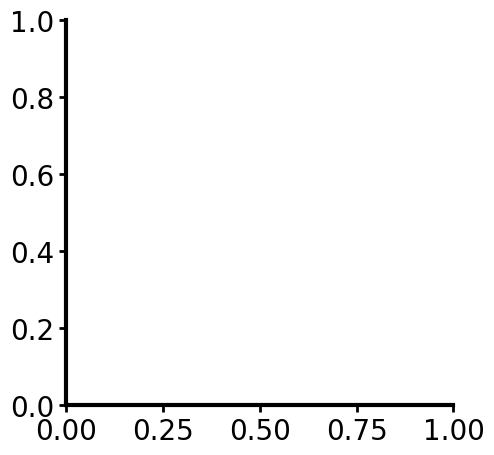

In [4]:
# Colormaps 
from matplotlib import colors
import matplotlib.cm as cm

cmap_wall = cm.binary
cmap_wall.set_under('k', alpha=0)

cmap_ch0 = colors.LinearSegmentedColormap.from_list(
    "", ["white", "xkcd:ultramarine"]
)

cmap_ch1 = colors.LinearSegmentedColormap.from_list(
    "", ["white", "xkcd:magenta"]
)

fig, ax = plt.subplots()

# Environment 
plt.imshow(1 - env_log[0][:, :, -1], clim=[0.1,1.0], cmap=cmap_wall, alpha=0.25, zorder=1)
plt.imshow((cmap_ch0(env[:,:,0]) + cmap_ch1(env[:,:,1]))/2)#, interpolation='gaussian', zorder=0) 

# Adjust axes 
# plt.xlim([(pk//2) - 1, width + pk//2])
# plt.ylim([height + pk//2, (pk//2) - 1]) 
# plt.axis("off")

Square arena with top wall containing (atleast) one target <br>
Only updated for static case currently

In [ ]:
def predator_trial(
    size,
    agnt,
    sensor_noise_scale,
    n_prey,
    pk,
    n_steps,
    scenario,
    motion,
    pc,
    pm=None,
    pe=None,
    log_env=False,
):
    """
    Tests a single agent on a single predator trial.
    Arguments:
        size: the size of the square environment.
        agnt: a network or algorithm which implements a policy function.
        sensor_noise_scale: added to each sensor at each time step.
        n_prey: the number of prey which start in the environment.
        pk: the width of the prey's Gaussian signal (in rc).
        n_steps: the number of steps the simulation lasts.
        scenario: defines the task as either foraging or hunting.
        motion: the type of motion used by the prey, either Static, Constant or Disappearing.
        pc: the persistence of cues in the environment from 0 to 1 (instantaneous to constant).
        pm: the probability of prey moving (per timestep) when hunting.
        pe: the probability of prey emitting cues (per timestep) when hunting.
        log_env: record the env state (True) or not (False).
    Returns:
        time: the number of steps taken to catch all prey.
              Returns n_steps-1 if the agent fails.
        path: a np array with the agent's location at each time step [r,c].
        prey state: a list with the final state (0 or 1, caught or free) of each prey.
        preys: a list containing the prey agents.
        env_log: a list storing the env at every step.
    """
    pk_hw = pk // 2  # half width of prey's Gaussian signal (in rc)

    # Create environment with track (1. and walls 0.)
    env = np.zeros((size, size, len(agnt.channels) + 1))
    env[:, :, -1] = 1.0
    env = np.pad(env, pad_width=((pk_hw, pk_hw), (pk_hw, pk_hw), (0, 0)))
    env_log = [np.copy(env)]

    # Reset agent
    agnt.location = np.array([pk_hw + (size // 2), pk_hw + (size // 2)])
    agnt.sensor_noise_scale = sensor_noise_scale
    agnt.outputs *= 0.0
    if agnt.type == "Hidden skip":
        agnt.memory = np.zeros_like(agnt.outputs)
    elif agnt.type == "Levy":
        agnt.flight_length = 0
        agnt.collision = 0

    # Define prey
    k1d = signal.windows.gaussian(pk, std=1)
    k2d = np.outer(k1d, k1d)
    k2d_noise = np.copy(k2d) 

    ## Location must be just in front of the top wall
    rcs = np.stack(np.argwhere(env[:, :, -1]))
    prey_rcs = np.random.choice(range(size), replace=False)
    preys = []
    for n in range(n_prey):
        preys.append(
            multimodal_mazes.AgentRandom(
                location=rcs[prey_rcs[n]], channels=[0, 0], motion=motion
            )
        )
        preys[n].state = 1  # free (1) or caught (0)
        preys[n].path = [list(preys[n].location)]

        if scenario == "Static": 
            preys[n].cues = n % 2  # channel for emitting cues

    # Sensation-action loop
    path = [list(agnt.location)]
    prey_counter = np.copy(n_prey)
    for time in range(n_steps):

        env[:, :, :-1] *= pc  # reset channels

        # Prey
        for prey in preys:
            if prey.state == 1:
                if (prey.location == agnt.location).all():  # caught
                    prey.state = 0
                    prey_counter -= 1

                else:  # free
                    prey.path.append(list(prey.location))

                    # Emit cues
                    r, c = prey.location
                    if scenario == "Static":
                        env[
                            r - pk_hw : r + pk_hw + 1,
                            c - pk_hw : c + pk_hw + 1,
                            prey.cues,
                        ] += np.copy(k2d)
        ## Some kind of termination needed if prey reaches an edge for moving cases

        # Apply edges
        for ch in range(len(agnt.channels)):
            env[:, :, ch] *= env[:, :, -1]

        # If all prey have been caught
        if prey_counter == 0:
            break

        # Log env
        if log_env:
            env_log.append(np.copy(env))

        # Predator
        agnt.sense(env)
        agnt.policy()
        agnt.act(env)

        path.append(list(agnt.location))

    return (
        time,
        np.array(path),
        [preys[n].state for n in range(n_prey)],
        preys,
        env_log,
    )


In [ ]:
def eval_predator_fitness(
    n_trials,
    size,
    agnt,
    sensor_noise_scale,
    n_prey,
    pk,
    n_steps,
    scenario,
    motion,
    pc,
    pm=None,
    pe=None,
):
    """
    Evaluates the fitness of an agent across multiple predator trials.
    Arguments:
        n_trials: the number of trials to run.
        size: the size of the square environment.
        agnt: a network or algorithm which implements a policy function.
        sensor_noise_scale: added to each sensor at each time step.
        n_prey: the number of prey which start in the environment.
        pk: the width of the prey's Gaussian signal (in rc).
        n_steps: the number of steps the simulation lasts.
        scenario: defines the task as either foraging or hunting.
        motion: the type of motion used by the prey, either Brownian or Levy.
        pc: the persistence of cues in the environment from 0 to 1 (instantaneous to constant).
        pm: the probability of prey moving (per timestep) when hunting.
        pe: the probability of prey emitting cues (per timestep) when hunting.
    Returns:
        fitness: the mean fitness across trials, between [0,1].
        times: a np vector with the length of each trial.
        paths: a list of np arrays with the predators' path per trial [r,c].
        preys: a list of lists containing the prey agents.
    """
    fitness, times, paths, preys = [], [], [], []

    # For each trial
    for _ in range(n_trials):
        # Run trial
        time, path, prey_state, prey, _ = predator_trial(
            size=size,
            agnt=agnt,
            sensor_noise_scale=sensor_noise_scale,
            n_prey=n_prey,
            pk=pk,
            n_steps=n_steps,
            scenario=scenario,
            motion=motion,
            pc=pc,
            pm=pm,
            pe=pe,
        )

        fitness.append(prey_state)
        times.append(time)
        paths.append(path)
        preys.append(prey)

    fitness = np.array(fitness)

    return (
        (1 - fitness).sum() / fitness.size,
        np.array(times),
        paths,
        preys,
    )


In [ ]:
def prey_params_search(
    grid_size, size, n_prey, n_steps, n_trials, pk, scenario, motion
):
    """
    Tests rule-based agents over a grid of task parameters.
    Arguments:
        grid_size: the number of values to test per parameter.
        size: the size of the square environment.
        n_prey: the number of prey which start in the environment.
        n_steps: the number of steps the simulation lasts.
        n_trials: the number of trials to run.
        pk: the width of the prey's Gaussian signal (in rc).
        scenario: defines the task as either foraging or hunting.
        motion: the type of motion used by the prey, either Brownian or Levy.
    Returns:
        results: a np array with the fitness results (noises, policies, pms, pes).
        parameters: a dictionary which stores the tested parameters and policies.
    """

    # Set up
    noises = np.linspace(start=0.0, stop=2.0, num=grid_size)
    policies = (
        multimodal_mazes.AgentRuleBased.policies
        + multimodal_mazes.AgentRuleBasedMemory.policies
        + ["Levy"]
    )
    colors = (
        multimodal_mazes.AgentRuleBased.colors
        + multimodal_mazes.AgentRuleBasedMemory.colors
        + [list(np.array([24, 156, 196, 255]) / 255)]
    )
    pms = np.linspace(start=0.0, stop=1.0, num=grid_size)
    pes = np.linspace(start=0.0, stop=1.0, num=grid_size)

    results = np.zeros((len(noises), len(policies), len(pms), len(pes)))

    # Test agents
    for a, noise in enumerate(noises):

        for b, policy in enumerate(policies):
            if policy in multimodal_mazes.AgentRuleBased.policies:
                agnt = multimodal_mazes.AgentRuleBased(
                    location=None, channels=[1, 1], policy=policy
                )
            elif policy in multimodal_mazes.AgentRuleBasedMemory.policies:
                agnt = multimodal_mazes.AgentRuleBasedMemory(
                    location=None, channels=[1, 1], policy=policy
                )
                agnt.alpha = 0.6
            elif policy == "Levy":
                agnt = multimodal_mazes.AgentRandom(
                    location=None, channels=[0, 0], motion=policy
                )

            for c, pm in enumerate(pms):
                for d, pe in enumerate(pes):
                    fitness, _, _, _ = multimodal_mazes.eval_predator_fitness(
                        n_trials=n_trials,
                        size=size,
                        agnt=agnt,
                        sensor_noise_scale=noise,
                        n_prey=n_prey,
                        pk=pk,
                        n_steps=n_steps,
                        scenario=scenario,
                        motion=motion,
                        pc=0.0,  # PLACE HOLDER
                        pm=pm,
                        pe=pe,
                    )

                    results[a, b, c, d] = fitness

    parameters = {
        "noises": noises,
        "policies": policies,
        "colors": colors,
        "pms": pms,
        "pes": pes,
    }

    return results, parameters
